## 
The World Health Organization (WHO) estimates that 17.9 million people die every year because of cardiovascular diseases (CVDs).

There are multiple risk factors that could contribute to CVD in an individual such as unhealthy diet, lack of physical activity or mental illnesses. Being able to identify these risk factors in individuals early on could help prevent a lot of premature deaths.

In this project, we will use the Kaggle dataset and build a K-Nearest Neighbors classifier to accurately predict the likelihood of a patient having a heart disease in the future.

In [188]:
# import libraries
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## EDA: Descriptive Statistics
We will start with exploring our dataset. As per the source, each patient has the following information collected about them:

Age: age of the patient [years]
Sex: sex of the patient [M: Male, F: Female]
ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
RestingBP: resting blood pressure [mm Hg]
Cholesterol: serum cholesterol [mm/dl]
FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
Oldpeak: oldpeak = ST [Numeric value measured in depression]
ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
HeartDisease: output class [1: heart disease, 0: Normal]

In [195]:
df = pd.read_csv("/Users/sravyajonnalagadda/Downloads/heart.csv") 
df.head(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [197]:
df.shape

(918, 12)

## The dataset seems to contain both numerical and categorical features. Let's look at the datatype for each column.

In [199]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [201]:
df.describe()


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


## From the table above, we can observe that:

The average age of patients is ~53 years.
The median for Cholesterol is higher than its mean by roughly 25 mm/dl, indicating that it could be a left-skewed distribution with a possibility of outliers skewing the distribution.
RestingBP and Cholesterol have a minimum value of zero.
There don't seem to be any missing values in these columns. But we will have to confirm it across the entire dataset as well.
RestingBP can't be 0. And, as per the American Heart Association, serum cholesterol is a composite of different measurements. So, it is unlikely that Cholesterol would be 0 as well. We will have to clean both of these up later.

Next, we will look at the categorical variables. It would also be beneficial to look at how the target feature, HeartDisease, is related to those categories. Before that, let's quickly check if there are any missing values in the dataset or not.

In [203]:
df.dtypes.value_counts()

int64      6
object     5
float64    1
Name: count, dtype: int64

## 7 features in total are numerical while 5 are categorical. However, two of the numerical features, FastingBS and HeartDisease are categorical as well.

We will focus on the numerical variables first.

In [117]:
df.value_counts()

Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  MaxHR  ExerciseAngina  Oldpeak  ST_Slope  HeartDisease
28   M    ATA            130        132          0          LVH         185    N               0.0      Up        0               1
58   M    ASY            128        216          0          LVH         131    Y               2.2      Flat      1               1
                         130        0            0          ST          100    Y               1.0      Flat      1               1
                                    263          0          Normal      140    Y               2.0      Flat      1               1
                         132        458          1          Normal      69     N               1.0      Down      0               1
                                                                                                                                 ..
50   M    ASY            150        215          0          Normal      140    Y 

In [119]:
df.isnull().sum().sum()

0

## EDA: Categorical Data:

In [209]:
df.describe(include=['object'])

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
count,918,918,918,918,918
unique,2,4,3,2,3
top,M,ASY,Normal,N,Flat
freq,725,496,552,547,460


## 
We can confirm that those columns are indeed categorical given the number of unique values in each of them. But, we can't gather much else. Also, FastingBS and HeartDisease are categorical as well since they only contain binary values. We can confirm that quickly as well.

avg_age = df["Age"].mean()
avg_age

In [123]:
cat_cols = df.select_dtypes(include = ['object']).columns
cat_cols

Index(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], dtype='object')

In [125]:
df["FastingBS"].unique(), df["HeartDisease"].unique() 

(array([0, 1]), array([0, 1]))

In [127]:
num_cols = df.select_dtypes(include = ['int','float']).columns
num_cols

Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak',
       'HeartDisease'],
      dtype='object')

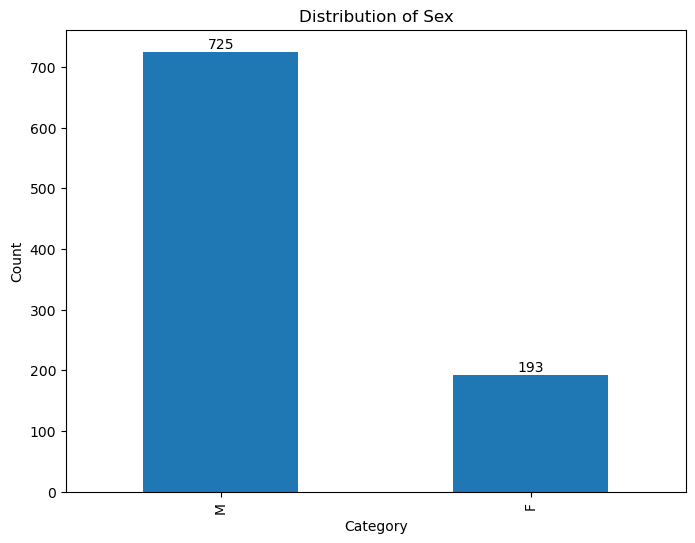

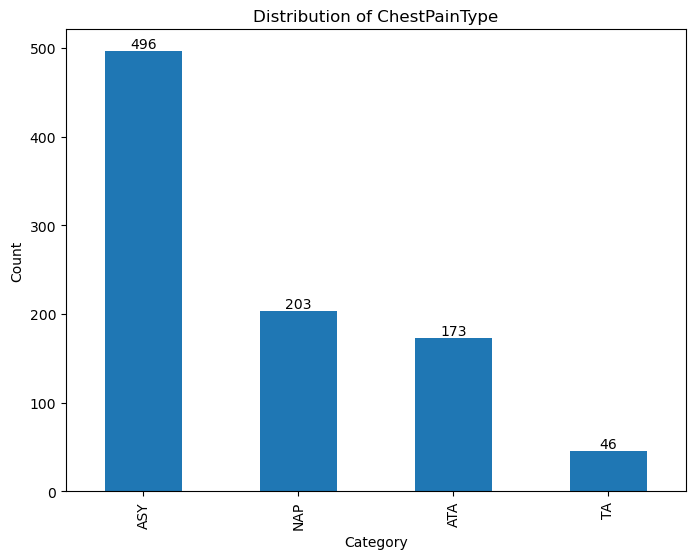

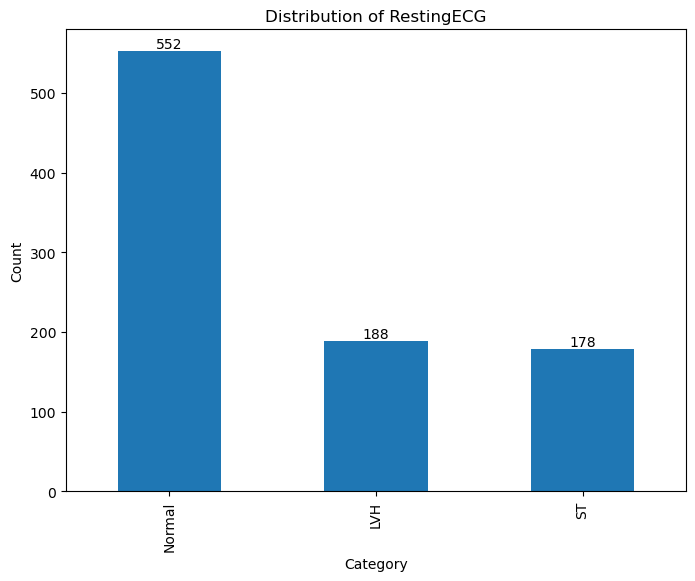

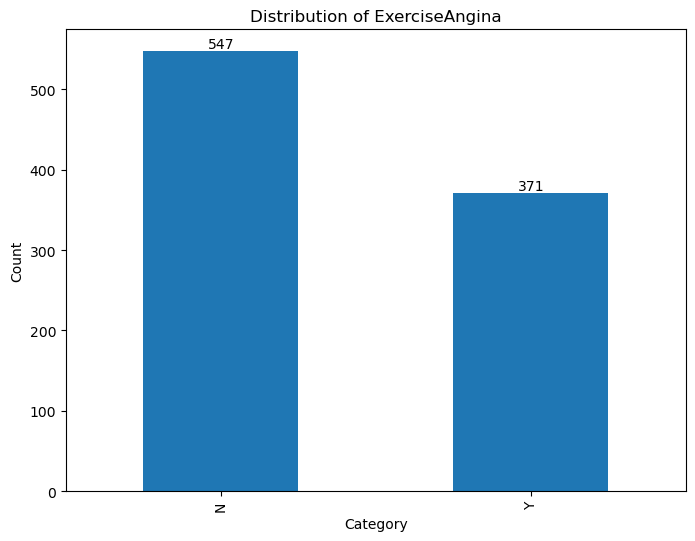

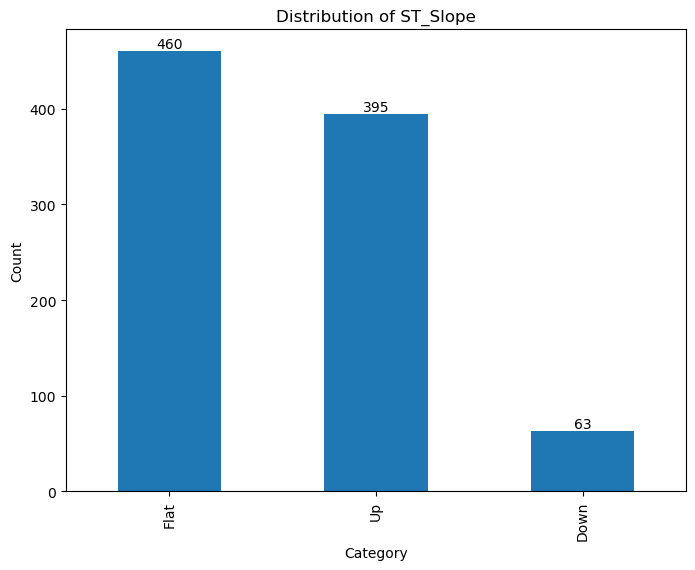

In [129]:
for col in cat_cols:
    plt.figure(figsize=(8,6))
    counts = df[col].value_counts()
    counts.plot(kind='bar')
    plt.title(f'Distribution of {col}')
    plt.xlabel('Category')
    plt.ylabel('Count')
    for p in plt.gca().patches:
        plt.gca().text(p.get_x() + p.get_width()/2, p.get_height(), f'{p.get_height():.0f}', ha='center', va='bottom')
    plt.show()

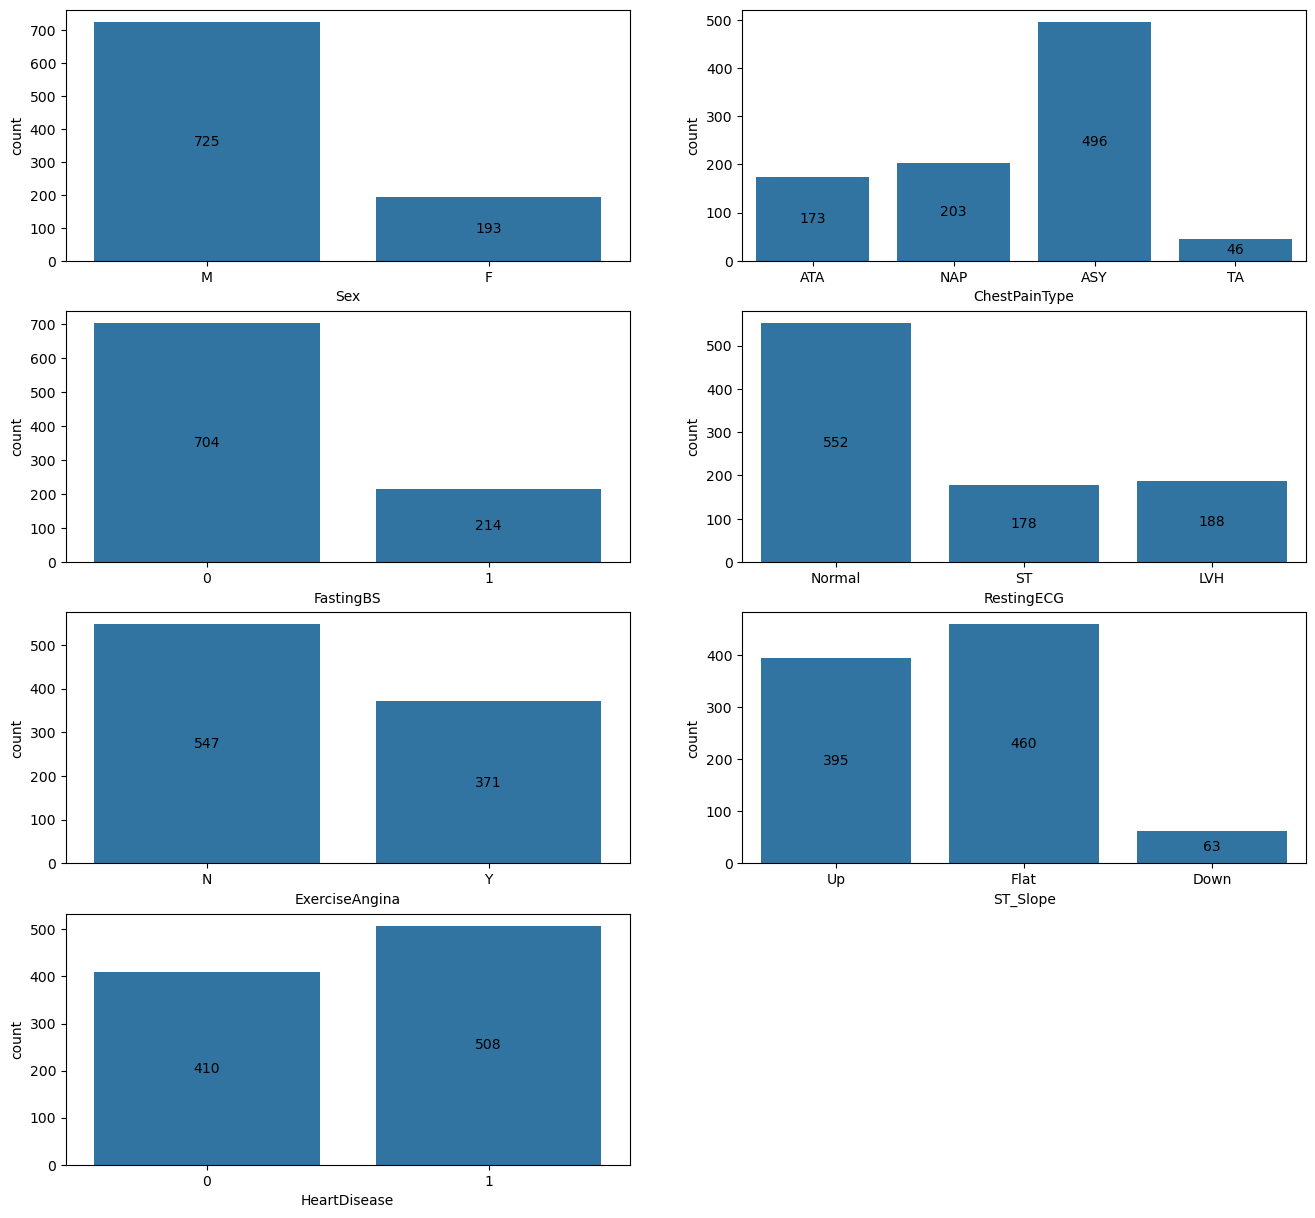

In [218]:
## Another way of Bar charts:
categorical_cols = ["Sex", "ChestPainType", "FastingBS", "RestingECG", "ExerciseAngina", "ST_Slope", "HeartDisease"]

fig = plt.figure(figsize=(16,15))

for idx, col in enumerate(categorical_cols):
    ax = plt.subplot(4, 2, idx+1)
    sns.countplot(x=df[col], ax=ax)
    # add data labels to each bar
    for container in ax.containers:
        ax.bar_label(container, label_type="center")

##
The dataset is highly skewed towards male patients. There are 725 male patients and 193 female patients. This could potentially induce a bias in our model.
496 patients had ASY (asymptotic) chest pain type.
552 patients had a normal restin ECG.
704 patients had blood sugar lower than 120 mg/dl
Grouping these by HeartDisease will give us a better idea about the data distribution.

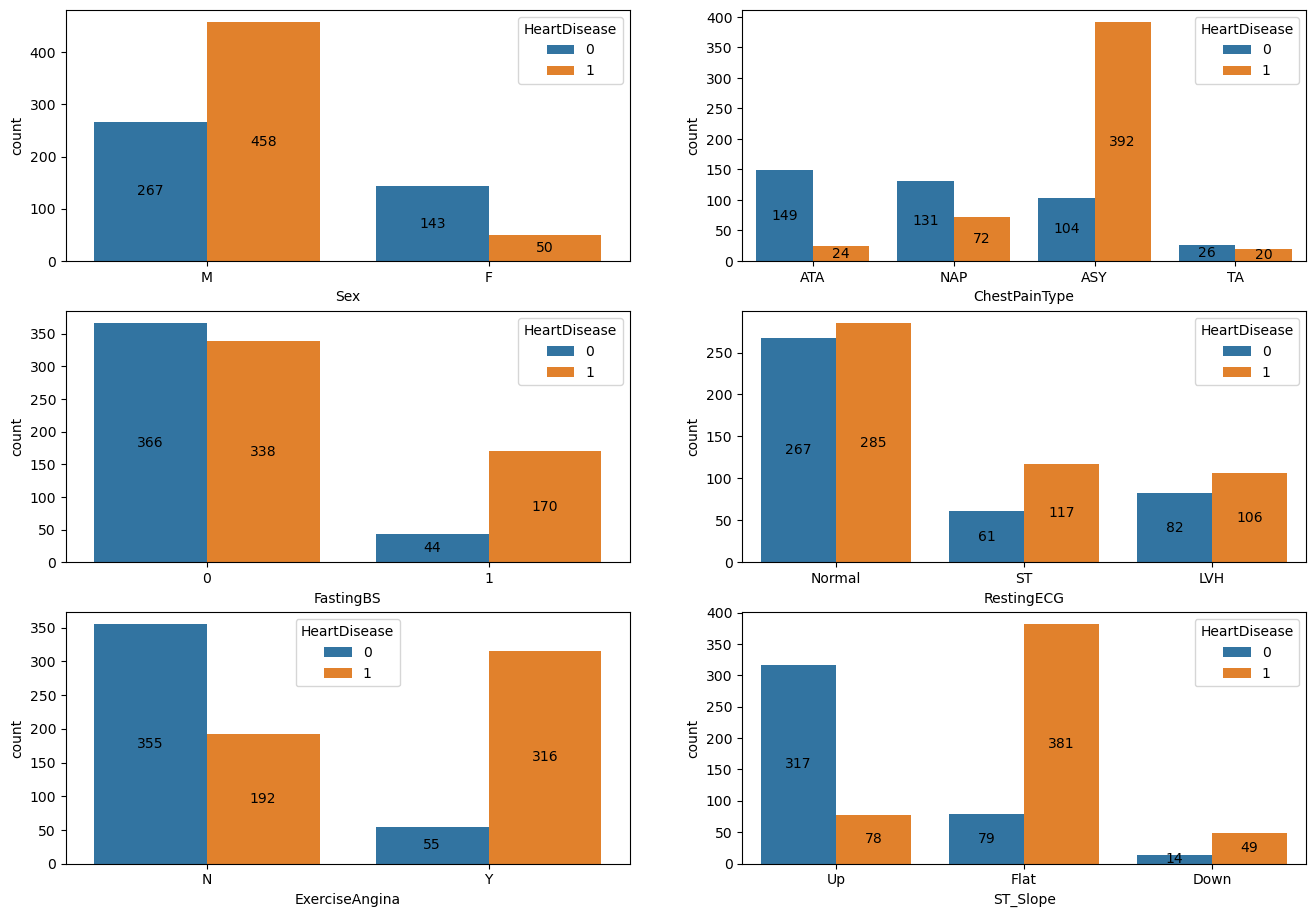

In [216]:
fig = plt.figure(figsize=(16,15))

for idx, col in enumerate(categorical_cols[:-1]):
    ax = plt.subplot(4, 2, idx+1)
    # group by HeartDisease
    sns.countplot(x=df[col], hue=df["HeartDisease"], ax=ax)
    # add data labels to each bar
    for container in ax.containers:
        ax.bar_label(container, label_type="center")

## 
We can further notice how skewed the dataset is towards male patients. Only 50 female patients in the dataset have been diagnosed with heart disease.
A significant number of patients, 392, diagnosed with heart disease have asymptomatic (ASY) chest pain. While chest pain could be a relevant feature for our model, asymptomatic implies that those patients who had a heart disease did not have chest pain as a symptom.
A high number (170) of patients with blood sugar greater than 120 mg/dl were diagnosed with heart disease in relation to those who were not diagnosed as such.
Out of all patients who had an exercise-induced angina, 316 were diagnosed with a heart disease.
Out of all patients with a flat ST slope, 381 were diagnosed with a heart disease.
Looking at the data distribution from the above plots, we can start to identify some features that could be relevant to us. We will clean up the dataset a bit first before narrowing down on our features.

## Data Cleaning

##
We identified that there are no missing values. However, as we noticed earlier, a couple of columns have 0 values which don't make sense.

We will look at how many zero values RestingBP and Cholesterol contain and decide how to handle those.

In [130]:
df[df["RestingBP"]==0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


In [131]:
df[df["Cholesterol"]==0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
297,57,M,ASY,110,0,1,ST,131,Y,1.4,Up,1
...,...,...,...,...,...,...,...,...,...,...,...,...
514,43,M,ASY,122,0,0,Normal,120,N,0.5,Up,1
515,63,M,NAP,130,0,1,ST,160,N,3.0,Flat,0
518,48,M,NAP,102,0,1,ST,110,Y,1.0,Down,1
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1


## RestingBP has only one zero value. We can remove that row from consideration. There are 172 zero values for Cholesterol. That's a relatively high number. We can't remove them all and replacing those values with the median might not be an ideal approach, but that's what we will go for now.

To be more accurate, we will replace the zero values in Cholesterol in relation to HeartDisease. So, the 0 values in Cholesterol for patients who were diagnosed with a heart disease will be replaced by the median of the non-zero values for patients who were diagnosed with a heart disase. And we'll do the same for those who were not diagnosed with a heart disease.

In [135]:
df_clean = df.copy()

# only keep non-zero values for RestingBP
df_clean = df_clean[df_clean["RestingBP"] != 0]

heartdisease_mask = df_clean["HeartDisease"]==0

cholesterol_without_heartdisease = df_clean.loc[heartdisease_mask, "Cholesterol"]
cholesterol_with_heartdisease = df_clean.loc[~heartdisease_mask, "Cholesterol"]

df_clean.loc[heartdisease_mask, "Cholesterol"] = cholesterol_without_heartdisease.replace(to_replace = 0, value = cholesterol_without_heartdisease.median())
df_clean.loc[~heartdisease_mask, "Cholesterol"] = cholesterol_with_heartdisease.replace(to_replace = 0, value = cholesterol_with_heartdisease.median())

In [137]:
df_clean.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [139]:
df_clean[["Cholesterol", "RestingBP"]].describe()

,Cholesterol,RestingBP
count,917.000000,917.000000
mean,239.700109,132.540894
std,54.352727,17.999749
min,85.000000,80.000000
25%,214.000000,120.000000
50%,225.000000,130.000000
75%,267.000000,140.000000
max,603.000000,200.000000


## Feature Selection:

## Thanks to our EDA and a general understanding of the features, we can identify some of the features that we could start with:

Age
Sex
ChestPainType
Cholesterol
FastingBS
We will also identify how stronly the feature columns are correlated to the target colummn. That should help us narrow down on the features.

In order to do that, we will first convert our categorical columns into dummy variables.

In [142]:
df_clean = pd.get_dummies(data = df_clean, drop_first = True) 

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,True,True,False,False,True,False,False,False,True
1,49,160,180,0,156,1.0,1,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0.0,0,True,True,False,False,False,True,False,False,True
3,48,138,214,0,108,1.5,1,False,False,False,False,True,False,True,True,False
4,54,150,195,0,122,0.0,0,True,False,True,False,True,False,False,False,True


<Axes: >

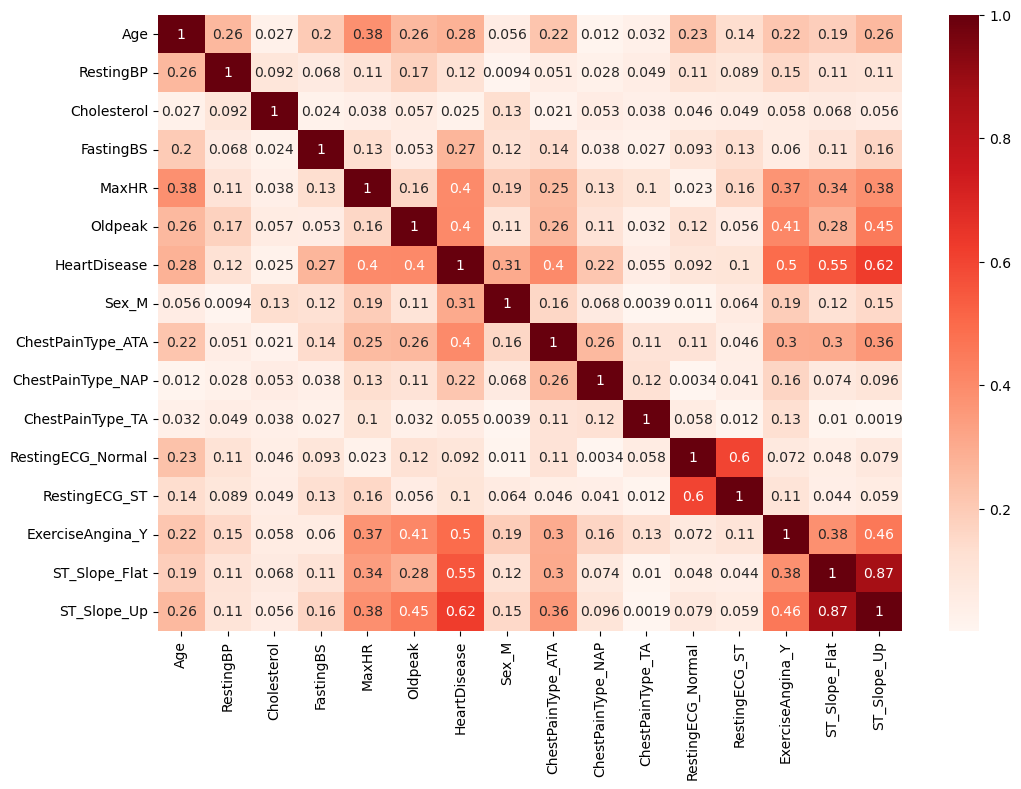

In [144]:
correlations = abs(df_clean.corr())
plt.figure(figsize = (12,8))
sns.heatmap(correlations,annot=True, cmap="Reds")

<Axes: >

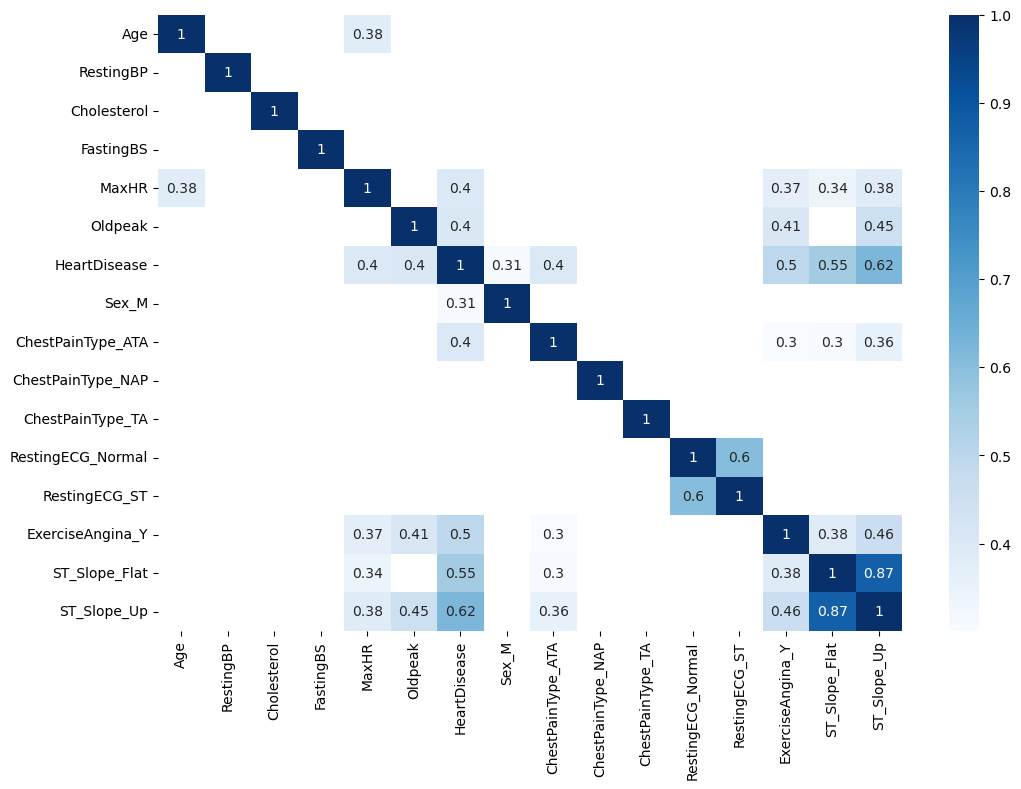

In [145]:

plt.figure(figsize=(12,8))
sns.heatmap(correlations[correlations > 0.3], annot=True, cmap="Blues")

## 
From our correlation heatmap, we can identify the following features to be positively correlated (correlation coefficient greater than 0.3) to HeartDisease:

Oldpeak
MaxHR
ChestPainType_ATA
ExerciseAngina_Y
ST_Slope_Flat
ST_Slope_Up
The correlation coefficient threshold was chosen arbitrarily. Surprisingly, Cholesterol is not strongly correlated to HeartDisease. We can consider ignoring the feature for now.

Given everything we have attempted so far, we can narrow down our features to the following:

Oldpeak
Sex_M
It has a relatively low value for the coefficient, but given what we observed in our EDA, let's also take it into account.
ExerciseAngina_Y
ST_Slope_Flat
ST_Slope_Up
Time to create our model using these features!

## Building a Classifier with One Feature:

In [150]:
X = df_clean.drop(["HeartDisease"], axis=1)
y = df_clean["HeartDisease"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state = 417)

features = [
    "Oldpeak",
    "Sex_M",
    "ExerciseAngina_Y",
    "ST_Slope_Flat",
    "ST_Slope_Up"
]

In [161]:
for feature in features:
    knn = KNeighborsClassifier(n_neighbors = 3)
    knn.fit(X_train[[feature]], y_train)
    accuracy = knn.score(X_val[[feature]], y_val)
    print(f"The k-NN classifier trained on {feature} and with k = 3 has an accuracy of {accuracy*100:.2f}%")

The k-NN classifier trained on Oldpeak and with k = 3 has an accuracy of 78.26%
The k-NN classifier trained on Sex_M and with k = 3 has an accuracy of 61.59%
The k-NN classifier trained on ExerciseAngina_Y and with k = 3 has an accuracy of 73.19%
The k-NN classifier trained on ST_Slope_Flat and with k = 3 has an accuracy of 81.88%
The k-NN classifier trained on ST_Slope_Up and with k = 3 has an accuracy of 84.06%


## Building a Classifier with Multiple Features:

In [157]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[features])
X_val_scaled = scaler.transform(X_val[features])


In [159]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train_scaled, y_train)
accuracy = knn.score(X_val_scaled, y_val)
print(f"Accuracy: {accuracy*100:.2f}")

Accuracy: 84.06


## Hyperparameter Optimization

In [164]:
X = df_clean.drop(["HeartDisease"], axis=1)
y = df_clean["HeartDisease"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state = 417)

features = [
    "Oldpeak",
    "Sex_M",
    "ExerciseAngina_Y",
    "ST_Slope_Flat",
    "ST_Slope_Up"
]

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[features])

## We will use grid search to explore the following range of values for a couple of hyperparameters:

For k (n_neighbors in scikit-learn) we will use values in the range of 1 to 20.
We will use two distance metrics - minkwoski and manhattan.
minkwoski is the default metric for KNeighborsClassifier in sklearn, so we don't expect manhattan to do better. But, let's see what happens!

In [169]:
grid_params = {"n_neighbors": range(1, 20),
                "metric": ["minkowski", "manhattan"]
              }

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, grid_params, scoring='accuracy')
knn_grid.fit(X_train_scaled, y_train)


GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['minkowski', 'manhattan'],
                         'n_neighbors': range(1, 20)},
             scoring='accuracy')

In [171]:
knn_grid.best_score_*100, knn_grid.best_params_

(83.18114143920594, {'metric': 'minkowski', 'n_neighbors': 16})

## (83.43507030603806, {'metric': 'minkowski', 'n_neighbors': 19})
Our best model had an accuracy of ~83% with 19 n_neighbors and minkowski as the distance metric.

The accuracy of this model is only slightly better. Since GridSearchCV employs a cross-validation approach, it is reasonable to assume that this is a better estimate of how the model performs compared to our prior attempt.

We will evaluate our model on our test set now.

## Model Evaluation on Test Set

## 
We need to first normalize our test set similar to how we scaled our training set.

In [176]:
X_test_scaled = scaler.transform(X_test[features])
predictions = knn_grid.best_estimator_.predict(X_test_scaled)
accuracy = accuracy_score(y_test, predictions)
print(f" Model Accuracy on test set: {accuracy*100:.2f}")

 Model Accuracy on test set: 87.68


##  Model Accuracy on test set: 87.68
Our model got an accuracy of ~88%. That's really good! This means that our model is likely to correctly predict whether a patient is at risk for a heart disease ~87% of the time.

However, the accuracy being higher than the one before raises some flags.

One explanation that could explain is to look at how the data is distributed.

In [179]:
print("Distribution of patients by their sex in the entire dataset")
print(X.Sex_M.value_counts())

print("\nDistribution of patients by their sex in the training dataset")
print(X_train.Sex_M.value_counts())

print("\nDistribution of patients by their sex in the test dataset")
print(X_test.Sex_M.value_counts())

Distribution of patients by their sex in the entire dataset
Sex_M
True     724
False    193
Name: count, dtype: int64

Distribution of patients by their sex in the training dataset
Sex_M
True     615
False    164
Name: count, dtype: int64

Distribution of patients by their sex in the test dataset
Sex_M
True     109
False     29
Name: count, dtype: int64


##
We can see that the above datasets have a significantly higher number of male patients than female ones. We briefly mentioned previously that this could present a bias because of this imbalance in our dataset and we can see it potentially impacts our model. If the test dataset doesn't have that many female patients and the model was trained on a dataset with more male patients, then it is understandable it has better accuracy on the test set. Of course, there could be other factors contributing to this discrepancy.

## Summary and Next Steps


## Our final model was trained using the following features:

Oldpeak
Sex_M
ExerciseAngina_Y
ST_Slope_Flat
ST_Slope_Up
and had a test set accuracy of 86.96%. However, given the limitations of our data this accuracy might not be indicative of a well performing model.

There are quite a few things we could try next to get better results:

Try out different features.
Expand the grid search parameters to identify more optimal hyperparameters.
Explore other algorithms that might perform better than k-NN.
Try and collect more data.